In [1]:
import os
import numpy as np
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from sklearn.metrics import accuracy_score
from sys import getsizeof

In [2]:
print(tf.__version__)

2.6.0


In [3]:

def get_file_size(file_path):
    size = os.path.getsize(file_path)
    return size

In [4]:
def convert_bytes(size, unit=None):
    if unit == "KB":
        return print('File size: ' + str(round(size / 1024, 3)) + ' Kilobytes')
    elif unit == "MB":
        return print('File size: ' + str(round(size / (1024 * 1024), 3)) + ' Megabytes')
    else:
        return print('File size: ' + str(size) + ' bytes')

# Import the Fashion MNIST dataset

In [5]:
fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [6]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Explore the data

In [7]:
train_images.shape

(60000, 28, 28)

In [8]:
np.unique(train_labels)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

# Test Dataset

In [9]:
test_images.shape

(10000, 28, 28)

# Preprocessing

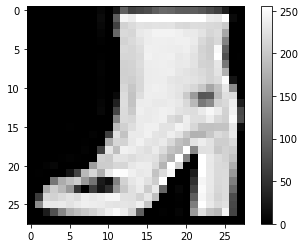

'Ankle boot'

In [13]:
plt.figure()
plt.imshow(train_images[88], cmap="gray")
plt.colorbar()
plt.grid(False)
plt.show()
class_names[train_labels[88]]

In [14]:
train_images = train_images / 255.0
test_images = test_images / 255.0


# Build & Compile the mode

In [15]:
model = keras.Sequential([
    Flatten(input_shape=(28, 28)),
    Dense(128, activation='relu'),
    Dense(10)
])

In [16]:
model.compile(optimizer='adam',
              loss= SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [17]:
model.fit(train_images, train_labels, epochs=10)

Epoch 1/10
1875/1875 [==============================] - 6s 2ms/step - loss: 0.4965 - accuracy: 0.8254
Epoch 2/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3695 - accuracy: 0.8679
Epoch 3/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3364 - accuracy: 0.8784
Epoch 4/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3120 - accuracy: 0.8851
Epoch 5/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.2929 - accuracy: 0.8919
Epoch 6/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2793 - accuracy: 0.8960
Epoch 7/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2673 - accuracy: 0.9011
Epoch 8/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2566 - accuracy: 0.9042
Epoch 9/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2479 - accuracy: 0.9062
Epoch 10/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.238

In [18]:
KERAS_MODEL_NAME = "tf_model_fashion_mnist.h5"
model.save(KERAS_MODEL_NAME)

In [19]:
convert_bytes(get_file_size(KERAS_MODEL_NAME), "MB")

File size: 1.19 Megabytes


In [21]:

keras_model_size = get_file_size(KERAS_MODEL_NAME)

In [22]:
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)
print('\nTest accuracy is {}%'.format(round(100*test_acc, 2)))

313/313 - 1s - loss: 0.3495 - accuracy: 0.8788

Test accuracy is 87.88%


# TF Lite Model

In [23]:
TF_LITE_MODEL_FILE_NAME = "tf_lite_model.tflite"

tf_lite_converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = tf_lite_converter.convert()

INFO:tensorflow:Assets written to: C:\Users\rabin\AppData\Local\Temp\tmpl_drlgs4\assets


In [24]:
tflite_model_name = TF_LITE_MODEL_FILE_NAME
open(tflite_model_name, "wb").write(tflite_model)

408544

In [26]:
convert_bytes(get_file_size(TF_LITE_MODEL_FILE_NAME), "KB")

File size: 398.969 Kilobytes


In [28]:
tflite_file_size = get_file_size(TF_LITE_MODEL_FILE_NAME)
tflite_file_size

408544

# Check Input Tensor Shape

In [29]:
interpreter = tf.lite.Interpreter(model_path = TF_LITE_MODEL_FILE_NAME)
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

Input Shape: [ 1 28 28]
Input Type: <class 'numpy.float32'>
Output Shape: [ 1 10]
Output Type: <class 'numpy.float32'>


# Resize Tensor Shape

In [30]:
interpreter.resize_tensor_input(input_details[0]['index'], (10000, 28, 28))
interpreter.resize_tensor_input(output_details[0]['index'], (10000, 10))
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

Input Shape: [10000    28    28]
Input Type: <class 'numpy.float32'>
Output Shape: [10000    10]
Output Type: <class 'numpy.float32'>


In [31]:
test_images.dtype

dtype('float64')

In [33]:
test_imgs_numpy = np.array(test_images, dtype=np.float32)

In [34]:
test_imgs_numpy.dtype

dtype('float32')

In [35]:
interpreter.set_tensor(input_details[0]['index'], test_imgs_numpy)
interpreter.invoke()
tflite_model_predictions = interpreter.get_tensor(output_details[0]['index'])
print("Prediction results shape:", tflite_model_predictions.shape)
prediction_classes = np.argmax(tflite_model_predictions, axis=1)

Prediction results shape: (10000, 10)


In [38]:
acc = accuracy_score(prediction_classes, test_labels)

print('Test accuracy TFLITE model is {}%'.format(round(100*acc, 2)))

Test accuracy TFLITE model is 87.88%


# TF Lite Model Float 16

In [39]:
TF_LITE_MODEL_FLOAT_16_FILE_NAME = "tf_lite_float_16_model.tflite"

In [40]:
tf_lite_converter = tf.lite.TFLiteConverter.from_keras_model(model)
tf_lite_converter.optimizations = [tf.lite.Optimize.DEFAULT]
tf_lite_converter.target_spec.supported_types = [tf.float16]
tflite_model = tf_lite_converter.convert()

INFO:tensorflow:Assets written to: C:\Users\rabin\AppData\Local\Temp\tmpo2zah77f\assets


INFO:tensorflow:Assets written to: C:\Users\rabin\AppData\Local\Temp\tmpo2zah77f\assets


In [41]:
tflite_model_name = TF_LITE_MODEL_FLOAT_16_FILE_NAME
open(tflite_model_name, "wb").write(tflite_model)

205696

In [42]:
convert_bytes(get_file_size(TF_LITE_MODEL_FLOAT_16_FILE_NAME), "KB")

File size: 200.875 Kilobytes


In [43]:
tflite_float_16_file_size = get_file_size(TF_LITE_MODEL_FLOAT_16_FILE_NAME)
tflite_float_16_file_size/keras_model_size

0.1648627853295717

In [44]:
tflite_float_16_file_size/tflite_file_size

0.5034855486801911

# TF Lite Size Quantized

In [45]:
TF_LITE_SIZE_QUANT_MODEL_FILE_NAME = "tf_lite_quant_model.tflite"

In [46]:
tf_lite_converter = tf.lite.TFLiteConverter.from_keras_model(model)
tf_lite_converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_model = tf_lite_converter.convert()

INFO:tensorflow:Assets written to: C:\Users\rabin\AppData\Local\Temp\tmpp4i0kcu1\assets


INFO:tensorflow:Assets written to: C:\Users\rabin\AppData\Local\Temp\tmpp4i0kcu1\assets


In [47]:
tflite_model_name = TF_LITE_SIZE_QUANT_MODEL_FILE_NAME
open(tflite_model_name, "wb").write(tflite_model)

103840

In [48]:
convert_bytes(get_file_size(TF_LITE_SIZE_QUANT_MODEL_FILE_NAME), "KB")

File size: 101.406 Kilobytes


In [49]:
tflite_float_quant_file_size = get_file_size(TF_LITE_SIZE_QUANT_MODEL_FILE_NAME)

tflite_float_quant_file_size/keras_model_size

0.08322646832521159

In [50]:
tflite_float_quant_file_size/ tflite_float_16_file_size

0.5048226509023024

# Accuracy of the Quantized Model

Check Input Tensor Shape

In [51]:
interpreter = tf.lite.Interpreter(model_path = TF_LITE_SIZE_QUANT_MODEL_FILE_NAME)
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

Input Shape: [ 1 28 28]
Input Type: <class 'numpy.float32'>
Output Shape: [ 1 10]
Output Type: <class 'numpy.float32'>


Resize Tensor Shape

In [52]:
interpreter.resize_tensor_input(input_details[0]['index'], (10000, 28, 28))
interpreter.resize_tensor_input(output_details[0]['index'], (10000, 10))
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

Input Shape: [10000    28    28]
Input Type: <class 'numpy.float32'>
Output Shape: [10000    10]
Output Type: <class 'numpy.float32'>


In [53]:
test_images.dtype

dtype('float64')

In [54]:
test_imgs_numpy = np.array(test_images, dtype=np.float32)

In [55]:
interpreter.set_tensor(input_details[0]['index'], test_imgs_numpy)
interpreter.invoke()
tflite_model_predictions = interpreter.get_tensor(output_details[0]['index'])
print("Prediction results shape:", tflite_model_predictions.shape)
prediction_classes = np.argmax(tflite_model_predictions, axis=1)

Prediction results shape: (10000, 10)


In [56]:
acc = accuracy_score(prediction_classes, test_labels)
print('Test accuracy TFLITE Quantized model is {}%'.format(round(100*acc, 2)))

Test accuracy TFLITE Quantized model is 87.88%
